# 1.Prepare data

## 1.1 Import

In [1]:
from datetime import datetime, date 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np
import re
tqdm.pandas()

## 1.2 read data

In [2]:
b_user_path = 'raw_data_production/b_user.csv'
b_uts_user_path = 'raw_data_production/b_uts_user.csv'
b_product_reviews_path = 'raw_data_production/b_product_review.csv'
b_iblock_element_path = 'raw_data_production/b_iblock_element.csv'
b_iblock_element_property_path = 'raw_data_production/b_iblock_element_property.csv'
b_iblock_section_path = 'raw_data_production/b_iblock_section.csv'
b_iblock_section_element_path = 'raw_data_production/b_iblock_section_element.csv'

b_user = pd.read_csv(b_user_path, low_memory=False, usecols=['ID', 'PERSONAL_PROFESSION', 'PERSONAL_GENDER', 'PERSONAL_BIRTHDAY'])
b_uts_user = pd.read_csv(b_uts_user_path, low_memory=False, usecols=['VALUE_ID', 'UF_EDU', 'UF_BLOODGROUP', 'UF_SHAPE', 'UF_HAIRLONG', 'UF_HAIRPROP', 'UF_SKINCOLOR', 'UF_SKINFACE', 'UF_SKINPROBLEM', 
    'UF_MAKEUPTIME', 'UF_PRODUCT_HAIR', 'UF_PRODUCT_SKINCARE', 'UF_PRODUCT_MAKEUP', 'UF_BUDGET', 'UF_BUYPERMONTH', 'UF_HAIRNATURE', 'UF_HAIRSIZE', 'UF_BODYCOLOR', 'UF_BODYTYPE', 'UF_BODYPROBLEM', 
    'UF_HAIRTYPE'])
b_product_reviews = pd.read_csv(b_product_reviews_path, low_memory=False, lineterminator='\n', usecols=['ID', 'EID', 'UID', 'POINT', 'EFFECT', 'LOCATION'])
b_iblock_element = pd.read_csv(b_iblock_element_path, low_memory=False, usecols=['ID', 'ACTIVE', 'IBLOCK_SECTION_ID'])
b_iblock_element_property = pd.read_csv(b_iblock_element_property_path, low_memory=False, usecols=['IBLOCK_PROPERTY_ID', 'IBLOCK_ELEMENT_ID', 'VALUE'])
b_iblock_section = pd.read_csv(b_iblock_section_path, low_memory=False, usecols=['ID', 'IBLOCK_ID', 'IBLOCK_SECTION_ID', 'DEPTH_LEVEL'])
b_iblock_section_element = pd.read_csv(b_iblock_section_element_path, low_memory=False, usecols=['IBLOCK_SECTION_ID', 'IBLOCK_ELEMENT_ID'])

## 1.3 clean data

### 1.3.1 product feature

In [3]:
product_feature = b_iblock_element[b_iblock_element['ACTIVE'] == 'Y'].drop(columns=['ACTIVE'])
product_feature.head(1)

,ID,IBLOCK_SECTION_ID
0,91,NaN


In [4]:
cat_subcat = b_iblock_section[b_iblock_section['IBLOCK_ID'] == 6].drop(columns=['IBLOCK_ID'])
cat_subcat_merge = b_iblock_section_element.merge(cat_subcat, left_on='IBLOCK_SECTION_ID', right_on='ID')
duplicate_cat_subcat = cat_subcat_merge[cat_subcat_merge['IBLOCK_ELEMENT_ID'].duplicated(keep=False)].reset_index()
all_duplicate_index = duplicate_cat_subcat['index']
deep_depth = duplicate_cat_subcat.groupby('IBLOCK_ELEMENT_ID').agg({'DEPTH_LEVEL': 'max'}).reset_index()
duplicate_cat_subcat_keep = duplicate_cat_subcat.merge(deep_depth, on=['IBLOCK_ELEMENT_ID', 'DEPTH_LEVEL'])['index']
outer_intersect = all_duplicate_index[~(all_duplicate_index.isin(duplicate_cat_subcat_keep))]
cat_subcat_merge.drop(outer_intersect.values, inplace=True)

cat_subcat_merge['IBLOCK_SECTION_ID_y'].fillna(cat_subcat_merge['IBLOCK_SECTION_ID_x'], inplace=True)
cat_subcat_merge = cat_subcat_merge.merge(cat_subcat, left_on='IBLOCK_SECTION_ID_y', right_on='ID')
cat_subcat_merge['IBLOCK_SECTION_ID'].fillna(cat_subcat_merge['ID_y'], inplace=True)
cat_subcat_merge.loc[cat_subcat_merge[cat_subcat_merge['DEPTH_LEVEL_x'] != 3].index, 'IBLOCK_SECTION_ID_y'] = None
cat_subcat_merge['IBLOCK_SECTION_ID'] = cat_subcat_merge['IBLOCK_SECTION_ID'].astype('Int64')
cat_subcat_merge = cat_subcat_merge[['IBLOCK_ELEMENT_ID', 'IBLOCK_SECTION_ID_y', 'IBLOCK_SECTION_ID']]
cat_subcat_merge.columns = ['IBLOCK_ELEMENT_ID', 'SCID', 'CID']
product_feature = product_feature.merge(cat_subcat_merge, left_on='ID', right_on='IBLOCK_ELEMENT_ID').drop(columns=['IBLOCK_ELEMENT_ID'])
product_feature['SCID'] = product_feature['SCID'].astype('Int64')
product_feature.head(1)

,ID,IBLOCK_SECTION_ID,SCID,CID
0,102,1497.0,2595,53


In [5]:
brand_maker = b_iblock_section[b_iblock_section['IBLOCK_ID'] == 17].drop(columns=['IBLOCK_ID'])
product_feature = product_feature.merge(brand_maker, left_on='IBLOCK_SECTION_ID', right_on='ID')
product_feature['IBLOCK_SECTION_ID_y'].fillna(product_feature['ID_y'], inplace=True)
product_feature = product_feature.merge(brand_maker, left_on='IBLOCK_SECTION_ID_y', right_on='ID')
product_feature.loc[product_feature[product_feature['DEPTH_LEVEL_x'] == 1].index, 'ID_y'] = None
product_feature.drop(columns=['IBLOCK_SECTION_ID_x', 'IBLOCK_SECTION_ID_y', 'IBLOCK_SECTION_ID', 'DEPTH_LEVEL_y', 'DEPTH_LEVEL_x'], inplace=True)
product_feature.columns = ['ID', 'SCID', 'CID', 'BID', 'MID']
product_feature['BID'] = product_feature['BID'].astype('Int64')
product_feature.head(1)

,ID,SCID,CID,BID,MID
0,102,2595,53,1497,1159


### 1.3.2 user feature

In [6]:
today = date.today()
def convert_age(row):
    if pd.notnull(row) and str(row) >= '1970-01-01':
        born = datetime.strptime(str(row), '%Y-%m-%d').date() 
        age = today.year - born.year - ((today.month, today.day) < (born.month, born.day))
        return age
    else:
        return None

In [7]:
user_feature = b_user.merge(b_uts_user, left_on='ID', right_on='VALUE_ID', how='left')
user_feature['AGE'] = user_feature['PERSONAL_BIRTHDAY'].apply(lambda x: convert_age(x))
user_feature.drop(columns=['PERSONAL_BIRTHDAY', 'VALUE_ID'], inplace=True)
user_feature.head(1)

,ID,PERSONAL_PROFESSION,PERSONAL_GENDER,UF_EDU,UF_BLOODGROUP,UF_SHAPE,UF_HAIRLONG,UF_HAIRPROP,UF_SKINCOLOR,UF_SKINFACE,...,UF_PRODUCT_MAKEUP,UF_BUDGET,UF_BUYPERMONTH,UF_HAIRNATURE,UF_HAIRSIZE,UF_BODYCOLOR,UF_BODYTYPE,UF_BODYPROBLEM,UF_HAIRTYPE,AGE
0,1,พนักงานบริษัทเอกชน,F,ปริญญาตรี,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0


### 1.3.3 product review

In [8]:
product_not_avail_index = b_product_reviews[~(b_product_reviews['EID'].isin(product_feature['ID']))].index
b_product_reviews.drop(product_not_avail_index, inplace=True)

user_not_avail_index = b_product_reviews[~(b_product_reviews['UID'].isin(user_feature['ID']))].index
b_product_reviews.drop(user_not_avail_index, inplace=True)

b_product_reviews = b_product_reviews.groupby(['EID', 'UID']).agg({'POINT': 'mean'}).reset_index()

In [9]:
group_user_review = b_product_reviews.groupby('UID').agg({'EID': 'count'}).sort_values(by='EID', ascending=False).reset_index()
group_review = b_product_reviews.groupby('EID').agg({'UID': 'count', 'POINT': 'mean'}).sort_values(by='UID', ascending=False).reset_index()
count_UID = group_review.groupby('UID').agg({'UID':'count'}).rename(columns={'UID':'count'}).reset_index()
group_review.describe(), group_user_review.describe()

(                EID           UID         POINT
 count  13074.000000  13074.000000  13074.000000
 mean   21475.197797     11.030978      3.559376
 std    14675.696067     32.433965      0.944192
 min      102.000000      1.000000      0.000000
 25%     8246.750000      1.000000      3.000000
 50%    19005.500000      3.000000      3.557778
 75%    34619.500000      8.000000      4.250000
 max    52378.000000   1155.000000      5.000000,
                  UID           EID
 count   14975.000000  14975.000000
 mean    51383.680000      9.630651
 std     31418.790125     67.729506
 min         1.000000      1.000000
 25%     26916.000000      1.000000
 50%     49241.000000      2.000000
 75%     77291.000000      4.000000
 max    110829.000000   4409.000000)

Text(0, 0.5, 'group amount')

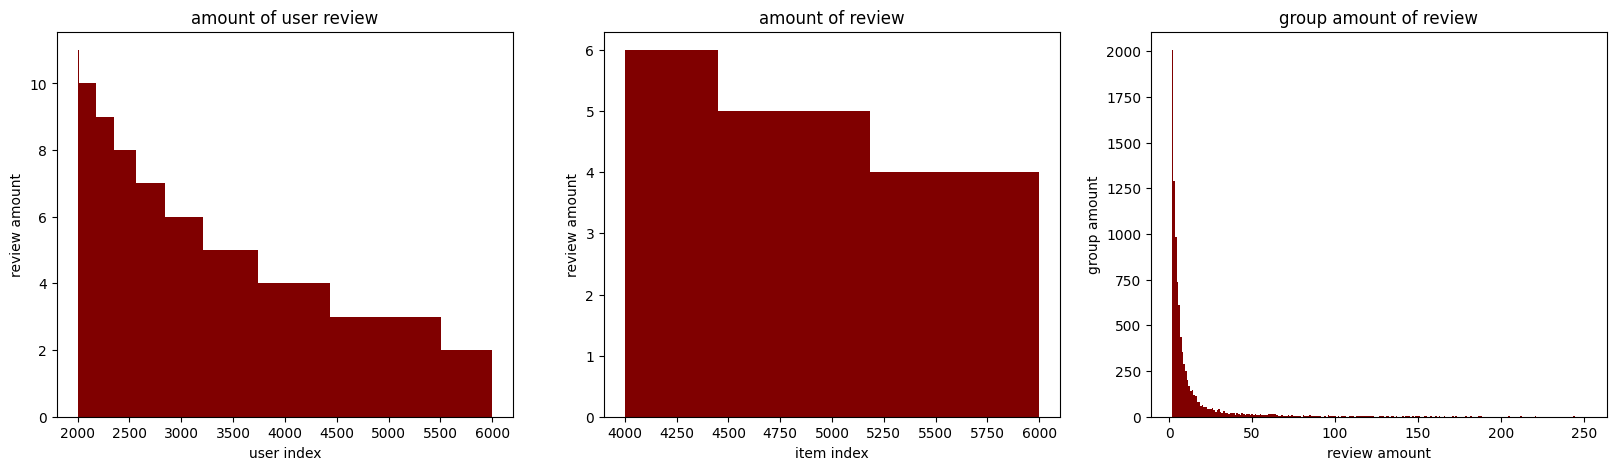

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(20)
group_user_review_min, group_user_review_max = 2000, 6000
group_review_min, group_review_max = 4000, 6000
count_UID_min, count_UID_max = 1, 200
ax1.bar(group_user_review.index[group_user_review_min:group_user_review_max], group_user_review['EID'][group_user_review_min:group_user_review_max], color ='maroon', width = 1)
ax1.set_title('amount of user review')
ax1.set_xlabel('user index')
ax1.set_ylabel('review amount')
ax2.bar(group_review.index[group_review_min:group_review_max], group_review['UID'][group_review_min:group_review_max], color ='maroon', width = 1)
ax2.set_title('amount of review')
ax2.set_xlabel('item index')
ax2.set_ylabel('review amount')
ax3.bar(count_UID['UID'][count_UID_min:count_UID_max], count_UID['count'][count_UID_min:count_UID_max], color ='maroon', width = 1)
ax3.set_title('group amount of review')
ax3.set_xlabel('review amount')
ax3.set_ylabel('group amount')

### 1.3.4 clean

In [10]:
def compute_sparsity_index(matrix):
    total = matrix.shape[0] * matrix.shape[1]
    non_zero = matrix.count().sum()
    return 1 - non_zero / total

def reduce_sparsity(df, min_items_per_user, min_user_per_item, user_col='UID', item_col='EID'):
    group_user = df.groupby(user_col).agg({item_col: 'count'})
    good_users = group_user[group_user[item_col] > min_items_per_user].index
    df = df[df[user_col].isin(good_users)]
    
    group_item = df.groupby(item_col).agg({user_col: 'count'})
    good_items = group_item[group_item[user_col] > min_user_per_item].index
    df = df[df[item_col].isin(good_items)].reset_index(drop=1)

    return df

def find_best_sparsity(df, user_col='UID', item_col='EID', max_loop=5, target_sparcity=None):
    last_zip = (0, 0, 1, 'feature') # user, item, sparsity, feature
    sparsity = compute_sparsity_index(df.pivot(index=user_col, columns=item_col, values='POINT'))
    history_sparsity= [(0, 0, sparsity, 'init')]
    def reduce(last_zip, history_sparsity):
        user_min_rev = last_zip[0] + 1
        user_df = reduce_sparsity(df, user_min_rev, last_zip[1])
        user_sparsity = compute_sparsity_index(user_df.pivot(index=user_col, columns=item_col, values='POINT'))
        while user_sparsity == history_sparsity[-1][2]:
            user_min_rev += 1
            user_df = reduce_sparsity(df, user_min_rev, last_zip[1])
            user_sparsity = compute_sparsity_index(user_df.pivot(index=user_col, columns=item_col, values='POINT'))
        
        item_min_rev = last_zip[1] + 1
        item_df = reduce_sparsity(df, last_zip[0], item_min_rev)
        item_sparsity = compute_sparsity_index(item_df.pivot(index=user_col, columns=item_col, values='POINT'))
        while item_sparsity == history_sparsity[-1][2]:
            item_min_rev += 1
            item_df = reduce_sparsity(df, item_min_rev, last_zip[1])
            item_sparsity = compute_sparsity_index(item_df.pivot(index=user_col, columns=item_col, values='POINT'))
        
        if user_sparsity < item_sparsity:
            last_zip = (user_min_rev, last_zip[1], user_sparsity, 'user')
        else:
            last_zip = (last_zip[0], item_min_rev, item_sparsity, 'item')
        history_sparsity.append(last_zip)
        return last_zip
    if target_sparcity is not None:
        while history_sparsity[-1][2] > target_sparcity:
            last_zip = reduce(last_zip, history_sparsity)
    else:
        for i in tqdm(range(max_loop)):
            last_zip = reduce(last_zip, history_sparsity)
    return history_sparsity

In [ ]:
raw_sparsity = compute_sparsity_index(b_product_reviews.pivot(index='UID', columns='EID', values='POINT'))
print(f"raw data: {raw_sparsity}")

In [ ]:
history = find_best_sparsity(b_product_reviews, target_sparcity=0.972)
df_history = pd.DataFrame(history, columns=['user', 'item', 'sparsity', 'feature'])
df_history.tail(3)

In [ ]:
review_filtered = reduce_sparsity(b_product_reviews, 13, 14)
new_sparsity = compute_sparsity_index(review_filtered.pivot(index='UID', columns='EID', values='POINT'))
print(f"new data: {new_sparsity}")

In [11]:
def concat_with_column_name(row):
    concatenated_values = []
    for col, val in row.items():
        if pd.notnull(val):
            convert_value = lambda vals: [f"{col}_{v.strip()}" for v in vals.split(',')if v.strip() != '']
            value = convert_value(val) if isinstance(val, str) else [f"{col}_{val}"]
            if value:
                concatenated_values += value
    return concatenated_values

In [15]:
product_feature = product_feature[product_feature['ID'].isin(review_filtered['EID'])]
product_feature.reset_index(drop=True, inplace=True)
user_feature = user_feature[user_feature['ID'].isin(review_filtered['UID'])]
user_feature.reset_index(drop=True, inplace=True)

In [37]:
num_pct_product = 20
pattern = r'\d{1,3}(?:,\d{3})*(?:\.\d+)?'
product_cost = b_iblock_element_property[b_iblock_element_property['IBLOCK_PROPERTY_ID'] == 48]
product_cost = product_cost[~(product_cost['VALUE'] == '-')]
product_cost['VALUE'] = product_cost['VALUE'].apply(lambda x: [float(cost.replace(',', '')) for cost in re.findall(pattern, x)])
pct_product = pd.Series(sum(product_cost['VALUE'], [])).quantile(np.linspace(0, 1, num_pct_product+1)).iloc[1:].reset_index()
product_cost['cost_percentile'] = product_cost['VALUE'].apply(lambda x: ','.join([str(int(pct_product.loc[pct_product[0] >= cost, 'index'].min()*100)) for cost in x]))
product_cost.drop(columns=['VALUE', 'IBLOCK_PROPERTY_ID'], inplace=True)
product_feature = product_feature.merge(product_cost, how='left', left_on='ID', right_on='IBLOCK_ELEMENT_ID').drop(columns=['IBLOCK_ELEMENT_ID'])

,IBLOCK_ELEMENT_ID,cost_percentile
156,9899,90


In [40]:
num_pct_user = 5
pct_user = user_feature['AGE'].dropna().quantile(np.linspace(0, 1, num_pct_user+1)).iloc[1:].reset_index()
user_feature['AGE'] = user_feature['AGE'].apply(lambda x: str(int(pct_user.loc[pct_user['AGE'] >= x, 'index'].min()*100)) if pd.notnull(x) else None)

In [47]:
product_feature.rename(columns={'ID': 'itemID'}, inplace=True)
user_feature.rename(columns={'ID': 'userID'}, inplace=True)
review_filtered.rename(columns={'EID': 'itemID', 'UID': 'userID'}, inplace=True)

product_feature['tag'] = ''
product_feature['tag'] = product_feature.drop(columns=['itemID']).progress_apply(lambda row: concat_with_column_name(row), axis=1)
user_feature['tag'] = ''
user_feature['tag'] = user_feature.drop(columns=['userID']).progress_apply(lambda row: concat_with_column_name(row), axis=1)

  0%|          | 0/1638 [00:00<?, ?it/s]

100%|██████████| 1638/1638 [00:00<00:00, 11884.10it/s]


## 1.4 Example data

In [17]:
from IPython.display import display ,HTML

review_filtered_html = f"<h3>review_filtered</h3>\n{review_filtered.head().to_html(index=False)}"
product_feature_html = f"<h3>product_feature</h3>\n{product_feature[['ID', 'tag']].head().to_html(index=False)}"
user_feature_html = f"<h3>user_feature</h3>\n{user_feature[['ID', 'tag']].head().to_html(index=False)}"

# Combine HTML for side-by-side display
html_combined = f"<div style='display: inline-block; margin-right: 20px;'>{review_filtered_html}</div>" \
                f"<div style='display: inline-block;'>{product_feature_html}</div>" \
                f"<div style='display: inline-block; margin-right: 20px;'>{user_feature_html}</div>"

# Display the HTML
display(HTML(html_combined))

In [18]:
# create a movie-user rating_matrix in DataFrame

import numpy as np
num_users = review_filtered.userID.unique().shape[0]
num_movies = review_filtered.itemID.unique().shape[0]

# movie_id --> index, user_id --> column
rating_matrix = pd.DataFrame(np.nan, index=range(1,num_movies+1), columns=range(1,num_users+1))

# assign ratings to appropriate elements of the matrix
for i in tqdm(range(review_filtered.shape[0])):
    rating_matrix.iloc[review_filtered.itemID[i]-1, review_filtered.userID[i]-1] = review_filtered.POINT[i]

# plot rating_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

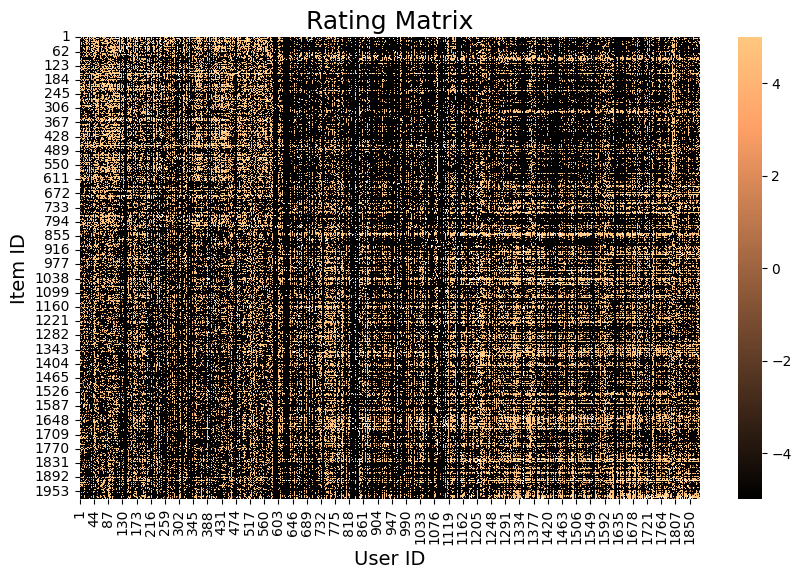

In [69]:
# Plot rating_matrix
plt.figure(figsize=(10, 6))
ax = sns.heatmap(rating_matrix, vmin=-5, vmax=5, cmap='copper')
ax.set_title('Rating Matrix', fontsize=18)
ax.set_xlabel('User ID', fontsize=14)
ax.set_ylabel('Item ID', fontsize=14)
plt.show()

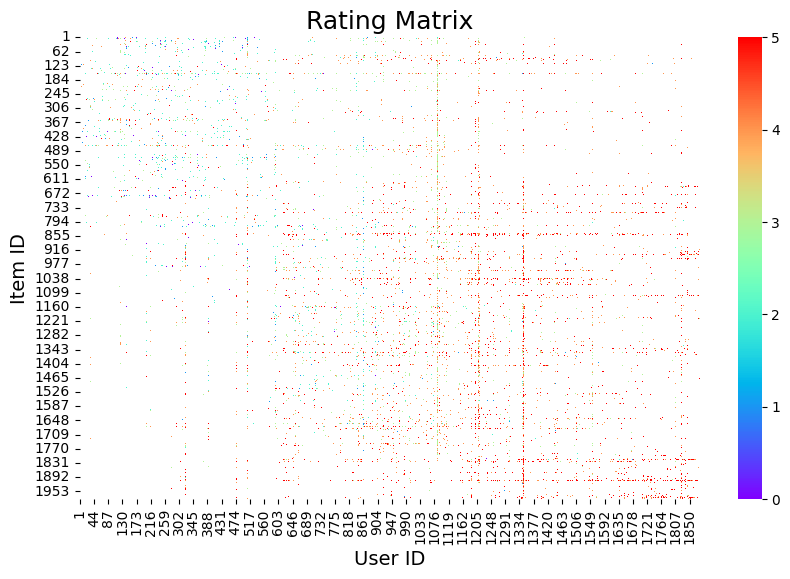

In [24]:
# Plot rating_matrix
plt.figure(figsize=(10, 6))
ax = sns.heatmap(rating_matrix, vmin=0, vmax=5, cmap='rainbow')
ax.set_title('Rating Matrix', fontsize=18)
ax.set_xlabel('User ID', fontsize=14)
ax.set_ylabel('Item ID', fontsize=14)
plt.show()

# 2. recommender with LightFM

## 2.1 Import libraries

In [12]:
import sys
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k
from lightfm.evaluation import auc_score as lightfm_auc_score
from lightfm.evaluation import reciprocal_rank as lightfm_reciprocal_rank

from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics,
    prepare_test_df,
    prepare_all_predictions,
    compare_metric,
    similar_users,
    similar_items,
)
from recommenders.utils.notebook_utils import store_metadata

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

System version: 3.8.10 (default, Nov 22 2023, 10:22:35) 
[GCC 9.4.0]
LightFM version: 1.17


## 2.2 Defining variables

In [13]:
# Select MovieLens data size
MOVIELENS_DATA_SIZE = '100k'

# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.25
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 200
# no of threads to fit model
NO_THREADS = 8
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6

# seed for pseudonumber generations
SEED = 42

## 2.3 Prepare data

Before fitting the LightFM model, we need to create an instance of `Dataset` which holds the interaction matrix.

In [28]:
dataset = Dataset()

The `fit` method creates the user/item id mappings.

In [29]:
# fit make user_id, item_id, user_feature, item_feature to unique and create new id
dataset.fit(users=review_filtered['userID'], 
            items=review_filtered['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 1880, num_topics: 1986.


Next is to build the interaction matrix. The `build_interactions` method returns 2 COO sparse matrices, namely the `interactions` and `weights` matrices.

In [32]:
# (user, item, weight) or (user, item) if weight is not available
(interactions, weights) = dataset.build_interactions(review_filtered.iloc[:, 2::-1].values)

LightLM works slightly differently compared to other packages as it expects the train and test sets to have same dimension. Therefore the conventional train test split will not work.

The package has included the `cross_validation.random_train_test_split` method to split the interaction data and splits it into two disjoint training and test sets. 

However, note that **it does not validate the interactions in the test set to guarantee all items and users have historical interactions in the training set**. Therefore this may result into a partial cold-start problem in the test set.

In [33]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED))

Double check the size of both the train and test sets.

In [34]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (1880, 1986)
Shape of test interactions: (1880, 1986)


## 2.4 Fit the LightFM model

In this notebook, the LightFM model will be using the weighted Approximate-Rank Pairwise (WARP) as the loss. Further explanation on the topic can be found [here](https://making.lyst.com/lightfm/docs/examples/warp_loss.html#learning-to-rank-using-the-warp-loss).


In general, it maximises the rank of positive examples by repeatedly sampling negative examples until a rank violation has been located. This approach is recommended when only positive interactions are present.

In [35]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE,                 
                 random_state=np.random.RandomState(SEED))

The LightFM model can be fitted with the following code:

In [44]:
model1.fit(interactions=train_interactions,
          epochs=NO_EPOCHS, verbose=True);

Epoch: 100%|██████████| 200/200 [00:16<00:00, 12.37it/s]


## 2.5 Prepare model evaluation data

Before we can evaluate the fitted model and to get the data into a format which is compatible with the existing evaluation methods within this repo, the data needs to be massaged slightly.

First the train/test indices need to be extracted from the `lightfm.cross_validation` method as follows:

In [45]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, interactions.col, interactions.data, 
    random_state=np.random.RandomState(SEED))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

Then the the mapping between internal and external representation of the user and item are extracted as follows:

In [46]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

Once the train/test indices and mapping are ready, the test dataframe can be constructed as follows:

In [57]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
time_reco1 = test_time.interval

100%|██████████| 19573/19573 [00:01<00:00, 18205.90it/s]

Took 2.2 seconds for prepare and predict test data.


And samples of the test dataframe:

In [59]:
test_df.sample(5, random_state=SEED)

,userID,itemID,rating
19551,1107,692,3.0
17609,1768,1970,5.0
5647,1025,1664,4.0
7826,1144,1191,3.0
10958,248,218,4.0


In addition, the predictions of all unseen user-item pairs (e.g. removing those seen in the training data) can be prepared as follows:

In [60]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(review_filtered, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model1, 
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

prepare all predictions


100%|██████████| 1880/1880 [00:00<00:00, 7723.27it/s]


map ratings


100%|██████████| 3733680/3733680 [02:33<00:00, 24389.47it/s]


predicting


100%|██████████| 3674963/3674963 [24:54<00:00, 2458.82it/s] 

Took 1672.2 seconds for prepare and predict all data.


Samples of the `all_predictions` dataframe:

In [62]:
all_predictions.sample(5, random_state=SEED)

,userID,itemID,prediction
2018741,1640,616,-43.426426
1563672,1050,1017,-28.857048
1589885,1428,211,-27.175879
256570,426,1084,-4.439978
2747815,1085,1196,-48.975956


Note that the **raw prediction values from the LightFM model are for ranking purposes only**, they should not be used directly. The magnitude and sign of these values do not have any specific interpretation.

## 2.6 Model evaluation

Once the evaluation data are ready, they can be passed into to the repo's evaluation methods as follows. The performance of the model will be tracked using both Precision@K and Recall@K.

In addition, the results have also being compared with those computed from LightFM's own evaluation methods to ensure accuracy.

In [63]:
with Timer() as test_time:
    eval_precision = precision_at_k(rating_true=test_df, rating_pred=all_predictions, k=K)
    eval_recall = recall_at_k(test_df, all_predictions, k=K)
time_reco3 = test_time.interval

with Timer() as test_time:
    eval_precision_lfm = lightfm_prec_at_k(model1, test_interactions, train_interactions, k=K).mean()
    eval_recall_lfm = lightfm_recall_at_k(model1, test_interactions, train_interactions, k=K).mean()
eval_auc_lfm = lightfm_auc_score(model1, test_interactions, train_interactions).mean()
time_lfm = test_time.interval
    
print(
    "------ Using Repo's evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    f"time:\t{time_reco3:.3f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Precision@K:\t{eval_precision_lfm:.6f}",
    f"Recall@K:\t{eval_recall_lfm:.6f}", 
    f"time:\t{time_lfm:.3f}",
    f"auc:\t{eval_auc_lfm:.6f}", 
    sep='\n')

------ Using Repo's evaluation methods ------
Precision@K:	0.067606
Recall@K:	0.061809
time:	14.036

------ Using LightFM evaluation methods ------
Precision@K:	0.067606
Recall@K:	0.061809
time:	0.798
auc:	0.740343


# 3. Movie recommender with LightFM using explicit feedbacks and additional item and user features

As the LightFM was designed to incorporates both user and item metadata, the model can be extended to include additional features such as movie genres and user occupations.

## 3.1 Extract and prepare feature

In this notebook, the movie's genres will be used as the item metadata. As the genres have already been loaded during the initial data import, it can be processed directly as follows:

In [19]:
# split the genre based on the separator
product_feature['product_tag'] = [x.split('|') for x in product_feature['tag']]
user_feature['user_tag'] = [x.split('|') for x in user_feature['tag']]

all_product_tag = sorted(list(set(itertools.chain.from_iterable(product_feature['product_tag']))))
all_user_tag = sorted(list(set(itertools.chain.from_iterable(user_feature['user_tag']))))

In [20]:
review_filtered = review_filtered.merge(product_feature[['ID', 'product_tag']], left_on='itemID', right_on='ID', how='left').drop(columns=['ID'])
review_filtered = review_filtered.merge(user_feature[['ID', 'user_tag']], left_on='userID', right_on='ID', how='left').drop(columns=['ID'])

## 3.2 Prepare data and features

Similar to the previous model, the data is required to be converted into a `Dataset` instance and then create a user/item id mapping with the `fit` method.

In [21]:
dataset = Dataset()
dataset.fit(review_filtered['userID'], 
            review_filtered['itemID'], 
            item_features=all_product_tag,
            user_features=all_user_tag)

The movie genres are then converted into a item feature matrix using the `build_item_features` method as follows:

In [22]:
item_features = dataset.build_item_features((x, y) if y is not np.nan else (x, []) for x,y in zip(review_filtered.itemID, review_filtered.product_tag))

The user occupations are then converted into an user feature matrix using the `build_user_features` method as follows:

In [23]:
user_features = dataset.build_user_features((x, y) if y is not np.nan else (x, []) for x,y in zip(review_filtered.userID, review_filtered.user_tag))

Once the item and user features matrices have been completed, the next steps are similar as before, which is to build the interaction matrix and split the interactions into train and test sets as follows:

In [24]:
interactions, weights = dataset.build_interactions(review_filtered.iloc[:, 2::-1].values)

train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, 
    test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED)
)

## 3.3 Fit the LightFM model with additional user and item features

The parameters of the second model will be similar to the first model to facilitates comparison.

The model performance at each epoch is also tracked by the same metrics as before.

In [25]:
model2 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEED)
                )

The LightFM model can then be fitted:

In [26]:
model2.fit(interactions=train_interactions,
           user_features=user_features,
           item_features=item_features,
           epochs=NO_EPOCHS,
           verbose=True
           )

Epoch: 100%|██████████| 200/200 [00:18<00:00, 10.66it/s]


## 3.4 Prepare model evaluation data

Similar to the previous model, the evaluation data needs to be prepared in order to get them into a format consumable with this repo's evaluation methods.

Firstly the train/test indices and id mappings are extracted using the new interations matrix as follows:

In [27]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, 
    interactions.col, 
    interactions.data, 
    random_state=np.random.RandomState(SEED)
)

uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

The test dataframe is then constructed as follows:

In [228]:
with Timer() as test_time:
    test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  

100%|██████████| 19573/19573 [00:01<00:00, 19502.89it/s]

Took 2.1 seconds for prepare and predict test data.


The predictions of all unseen user-item pairs can be prepared as follows:

In [229]:
with Timer() as test_time:
    all_predictions2 = prepare_all_predictions(review_filtered, uid_map, iid_map, 
                                              interactions=train_interactions,
                                               user_features=user_features,
                                               item_features=item_features,
                                               model=model2,
                                               num_threads=NO_THREADS)

print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

prepare all predictions


100%|██████████| 1880/1880 [00:00<00:00, 14833.58it/s]

map ratings



100%|██████████| 3733680/3733680 [02:35<00:00, 23989.76it/s]


predicting


100%|██████████| 3674963/3674963 [11:39<00:00, 5250.51it/s]

Took 880.0 seconds for prepare and predict all data.


## 3.5 Model evaluation and comparison

The predictive performance of the new model can be computed and compared with the previous model (which used only the explicit rating) as follows:

In [230]:
eval_precision2 = precision_at_k(rating_true=test_df2, 
                                rating_pred=all_predictions2, k=K)
eval_recall2 = recall_at_k(test_df2, all_predictions2, k=K)

print(
    "------ Using only explicit ratings ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using both implicit and explicit ratings ------",
    f"Precision@K:\t{eval_precision2:.6f}",
    f"Recall@K:\t{eval_recall2:.6f}",
    sep='\n')

------ Using only explicit ratings ------
Precision@K:	0.067606
Recall@K:	0.061809

------ Using both implicit and explicit ratings ------
Precision@K:	0.068093
Recall@K:	0.061607


The new model which used both implicit and explicit data performed consistently better than the previous model which used only the explicit data, thus highlighting the benefits of including such additional features to the model.

# 4. Evaluate model fitting process

In addition to the inclusion of both implicit and explicit data, the model fitting process can also be monitored in order to determine whether the model is being trained properly. 

This notebook also includes a `track_model_metrics` method which plots the model's metrics e.g. Precision@K and Recall@K as model fitting progresses.

For the first model (using only explicit data), the model fitting progress is shown as follows:

100%|██████████| 200/200 [09:24<00:00,  2.82s/it]


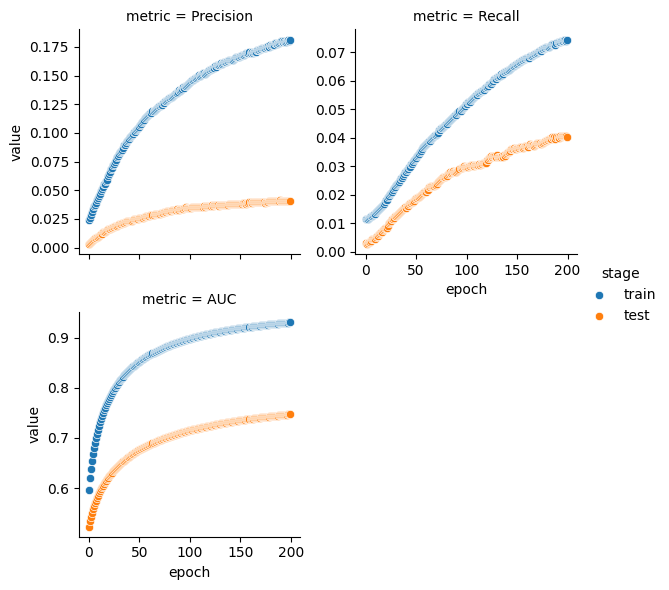

In [36]:
output1, _ = track_model_metrics(model=model1, 
                                 train_interactions=train_interactions, 
                                 test_interactions=test_interactions, 
                                 k=K,
                                 no_epochs=NO_EPOCHS, 
                                 no_threads=NO_THREADS)

The second model (with both implicit and explicit data) fitting progress:

100%|██████████| 200/200 [09:55<00:00,  2.98s/it]


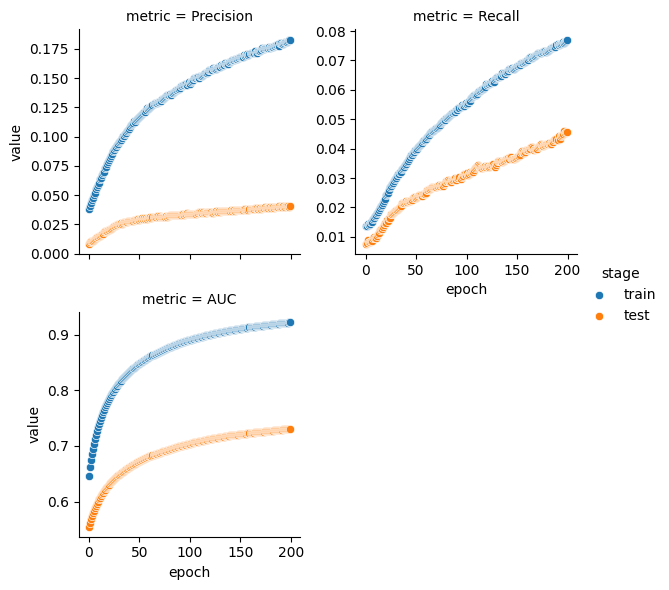

In [27]:
output2, _ = track_model_metrics(model=model2, 
                                 train_interactions=train_interactions, 
                                 test_interactions=test_interactions, 
                                 k=K,                              
                                 no_epochs=NO_EPOCHS, 
                                 no_threads=NO_THREADS, 
                                 item_features=item_features,
                                 user_features=user_features)

These show slightly different behaviour with the two approaches, the reader can then tune the hyperparameters to improve the model fitting process.


## 4.1 Performance comparison

In addition, the model's performance metrics (based on the test dataset) can be plotted together to facilitate easier comparison as follows:

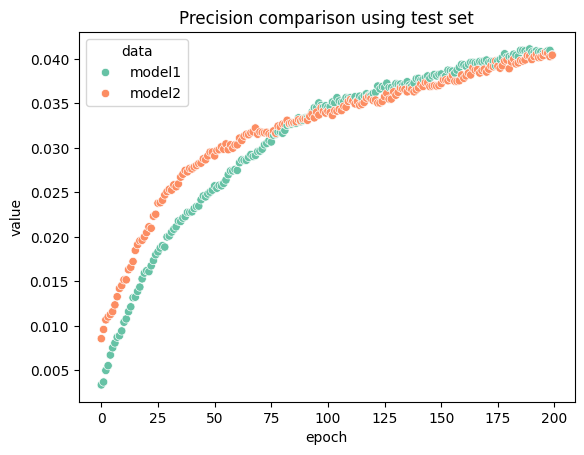

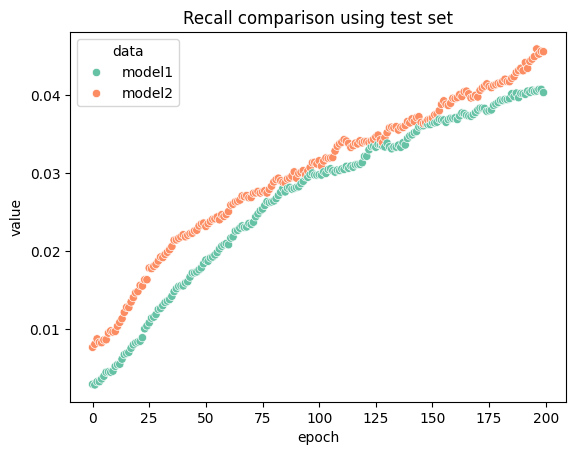

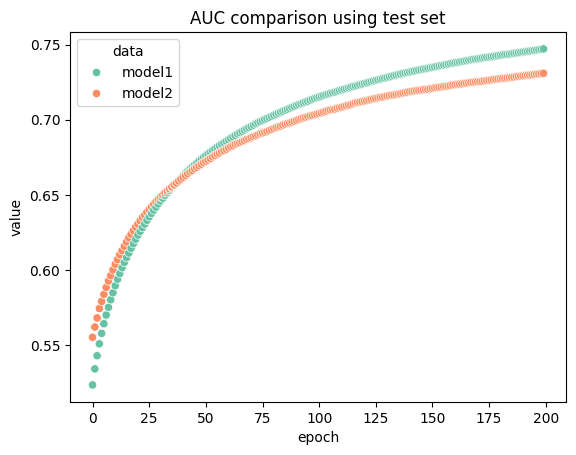

In [37]:
for i in ['Precision', 'Recall', 'AUC']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch", 
                    y="value", 
                    hue='data',
                    data=compare_metric(df_list = [output1, output2], metric=i)
                   ).set_title(f'{i} comparison using test set');

In [38]:
auc_score_1 = lightfm_auc_score( 
        model1, test_interactions, train_interactions,
        num_threads=8).mean()

auc_score_2 = lightfm_auc_score( 
        model2, test_interactions, train_interactions, user_features=user_features, item_features=item_features, 
        num_threads=8).mean()

In [39]:
auc_score_1, auc_score_2

(0.75390905, 0.7374651)

Referring to the figures above, it is rather obvious that the number of epochs is too low as the model's performances have not stabilised. Reader can decide on the number of epochs and other hyperparameters to adjust suit the application.

As stated previously, it is interesting to see model2 (using both implicit and explicit data) performed consistently better than model1 (using only explicit ratings). 

# 5. Similar users and items

As the LightFM package operates based on latent embeddings, these can be retrieved once the model has been fitted to assess user-user and/or item-item affinity.

## 5.1 User affinity

The user-user affinity can be retrieved with the `get_user_representations` method from the fitted model as follows:

In [40]:
_, user_embeddings = model2.get_user_representations(features=user_features)
user_embeddings

array([[-12.381987  , -17.476429  ,  17.645906  , ...,  19.391674  ,
        -16.623663  ,  15.00594   ],
       [  0.22812682,  -3.6864562 ,  -0.3585929 , ...,  -1.3580643 ,
         -1.303443  ,  -4.5651155 ],
       [ -8.355205  ,   7.9561386 ,  -0.9827686 , ...,   1.7220945 ,
         -3.6398292 ,  -5.227971  ],
       ...,
       [ -6.0412197 ,   2.9707675 ,  10.133899  , ...,   6.0465446 ,
          4.5835533 ,   0.38322774],
       [  1.5603329 ,  -1.0972943 ,   0.76399934, ...,   1.3821312 ,
          2.0206754 ,  -0.4307973 ],
       [  0.65224797,  12.862502  ,   7.464039  , ...,  -8.084565  ,
         -3.3106701 ,   9.935255  ]], dtype=float32)

In order to retrieve the top N similar users, we can use the `similar_users` from `recommenders`. For example, if we want to choose top 10 users most similar to the user 1:

In [41]:
similar_users(user_id=1, 
              user_features=user_features, 
              model=model2)

,userID,score
0,1131,0.787654
1,1041,0.726578
2,212,0.670690
3,15,0.643883
4,147,0.637099
5,143,0.604128
6,1078,0.593356
7,511,0.593257
8,9,0.579907
9,101,0.576623


## 5.2 Item affinity

Similar to the user affinity, the item-item affinity can be retrieved with the `get_item_representations` method using the fitted model.

In [42]:
_, item_embeddings = model2.get_item_representations(features=item_features)
item_embeddings

array([[ 2.2502697 , -4.9627395 , -0.2887232 , ...,  1.0075796 ,
        -2.1264014 , -1.3068163 ],
       [-2.4146144 ,  2.2141428 , -3.590482  , ...,  6.0472894 ,
        -0.9950707 ,  1.4453632 ],
       [-1.4266776 , -3.6233346 ,  1.493656  , ..., -0.98167115,
         0.11847199,  2.757232  ],
       ...,
       [-0.8219345 , -0.8386042 ,  1.2098947 , ..., -3.0215375 ,
         3.1401505 ,  2.5034142 ],
       [ 1.8139015 ,  1.1430784 ,  1.7142949 , ...,  0.188727  ,
        -1.9750546 ,  2.6970227 ],
       [ 2.1100585 ,  0.12181091, -5.3859944 , ..., -4.312385  ,
         2.7102575 ,  2.726043  ]], dtype=float32)

The function to retrieve the top N similar items is similar to similar_users() above. For example, if we want to choose top 10 items most similar to the item 10:

In [43]:
similar_items(item_id=10, 
              item_features=item_features, 
              model=model2)

,itemID,score
0,1183,0.618618
1,45,0.578455
2,689,0.573005
3,1782,0.564777
4,626,0.563606
5,1178,0.552858
6,355,0.549738
7,1136,0.544998
8,89,0.521170
9,156,0.508368


In [ ]:
# Record results for tests - ignore this cell
store_metadata("eval_precision", eval_precision)
store_metadata("eval_recall", eval_recall)
store_metadata("eval_precision2", eval_precision2)
store_metadata("eval_recall2", eval_recall2)


# 6. Tune hyperparameter

In [14]:
from prettytable import PrettyTable

In [15]:
def create_data(product_feature, user_feature, target_sparcity=0.98, num_pct_product=20, num_pct_user=5):
    product_feature = product_feature.copy()
    user_feature = user_feature.copy()
    history = find_best_sparsity(b_product_reviews, target_sparcity=target_sparcity)
    review_filtered = reduce_sparsity(b_product_reviews, history[-1][0], history[-1][1])
    
    product_feature = product_feature[product_feature['ID'].isin(review_filtered['EID'])]
    product_feature.reset_index(drop=True, inplace=True)
    user_feature = user_feature[user_feature['ID'].isin(review_filtered['UID'])]
    user_feature.reset_index(drop=True, inplace=True)
    
    pattern = r'\d{1,3}(?:,\d{3})*(?:\.\d+)?'
    product_cost = b_iblock_element_property[b_iblock_element_property['IBLOCK_PROPERTY_ID'] == 48]
    product_cost = product_cost[~(product_cost['VALUE'] == '-')]
    product_cost['VALUE'] = product_cost['VALUE'].progress_apply(lambda x: [float(cost.replace(',', '')) for cost in re.findall(pattern, x)])
    pct_product = pd.Series(sum(product_cost['VALUE'], [])).quantile(np.linspace(0, 1, num_pct_product+1)).iloc[1:].reset_index()
    product_cost['cost_percentile'] = product_cost['VALUE'].progress_apply(lambda x: ','.join([str(int(pct_product.loc[pct_product[0] >= cost, 'index'].min()*100)) for cost in x]))
    product_cost.drop(columns=['VALUE', 'IBLOCK_PROPERTY_ID'], inplace=True)
    product_feature = product_feature.merge(product_cost, how='left', left_on='ID', right_on='IBLOCK_ELEMENT_ID').drop(columns=['IBLOCK_ELEMENT_ID'])
    
    pct_user = user_feature['AGE'].dropna().quantile(np.linspace(0, 1, num_pct_user+1)).iloc[1:].reset_index()
    user_feature['AGE'] = user_feature['AGE'].apply(lambda x: str(int(pct_user.loc[pct_user['AGE'] >= x, 'index'].min()*100)) if pd.notnull(x) else None)
    
    product_feature.rename(columns={'ID': 'itemID'}, inplace=True)
    user_feature.rename(columns={'ID': 'userID'}, inplace=True)
    review_filtered.rename(columns={'EID': 'itemID', 'UID': 'userID'}, inplace=True)
    
    product_feature['product_tag'] = ''
    product_feature['product_tag'] = product_feature.drop(columns=['itemID']).progress_apply(lambda row: concat_with_column_name(row), axis=1)
    user_feature['user_tag'] = ''
    user_feature['user_tag'] = user_feature.drop(columns=['userID']).progress_apply(lambda row: concat_with_column_name(row), axis=1)

    review_filtered = review_filtered.merge(product_feature[['itemID', 'product_tag']], on='itemID', how='left')
    review_filtered = review_filtered.merge(user_feature[['userID', 'user_tag']], on='userID', how='left')
    
    all_product_tag = sorted(list(set(itertools.chain.from_iterable(review_filtered['product_tag']))))
    all_user_tag = sorted(list(set(itertools.chain.from_iterable(review_filtered['user_tag']))))

    dataset = Dataset()
    dataset.fit(review_filtered['userID'], 
                review_filtered['itemID'], 
                item_features=all_product_tag,
                user_features=all_user_tag)

    item_features = dataset.build_item_features((x, y) if y is not np.nan else (x, []) for x,y in zip(review_filtered.itemID, review_filtered.product_tag))
    user_features = dataset.build_user_features((x, y) if y is not np.nan else (x, []) for x,y in zip(review_filtered.userID, review_filtered.user_tag))
    
    interactions, weights = dataset.build_interactions(review_filtered.values[:, [1, 0, 2]])

    train_interactions, test_interactions = cross_validation.random_train_test_split(
        interactions, 
        test_percentage=TEST_PERCENTAGE,
        random_state=np.random.RandomState(SEED)
    )
    
    train_weights, test_weights = cross_validation.random_train_test_split(
        weights, 
        test_percentage=TEST_PERCENTAGE,
        random_state=np.random.RandomState(SEED)
    )
    
    return train_interactions, test_interactions, train_weights, test_weights, item_features, user_features, dataset

In [16]:
def create_model(train_interactions, test_interactions, train_weights, item_features, user_features, epochs=200, learning_rate=0.05, no_components=20, user_alpha=1e-6, item_alpha=1e-6, K=10, **kwargs):
    model = LightFM(loss='warp', 
                    random_state=np.random.RandomState(SEED),
                    learning_rate=learning_rate, 
                    no_components=no_components, 
                    user_alpha=user_alpha,
                    item_alpha=item_alpha,
                    **kwargs
                    )
    model.fit(interactions=train_interactions,
                user_features=user_features,
                item_features=item_features,
                sample_weight = train_weights,
                epochs=epochs,
                num_threads=8,
                verbose=True
                )

    model_prec_train = lightfm_prec_at_k(model, train_interactions, k=K, item_features=item_features, user_features=user_features, num_threads=8).mean()
    model_prec_test = lightfm_prec_at_k(model, test_interactions, k=K, item_features=item_features, user_features=user_features, num_threads=8).mean()

    model_rec_train = lightfm_recall_at_k(model, train_interactions, k=K, item_features=item_features,user_features=user_features, num_threads=8).mean()
    model_rec_test = lightfm_recall_at_k(model, test_interactions, k=K, item_features=item_features,user_features=user_features, num_threads=8).mean()
    
    model_auc_train = lightfm_auc_score(model, train_interactions, item_features=item_features,user_features=user_features, num_threads=8).mean()
    model_auc_test = lightfm_auc_score(model, test_interactions, item_features=item_features, user_features=user_features, num_threads=8).mean()
    
    model_reciprocal_train = lightfm_reciprocal_rank(model, train_interactions, item_features=item_features,user_features=user_features, num_threads=8).mean()
    model_reciprocal_test = lightfm_reciprocal_rank(model, test_interactions, item_features=item_features, user_features=user_features, num_threads=8).mean()
    return model, [model_prec_train, model_prec_test, model_rec_train, model_rec_test, model_auc_train, model_auc_test, model_reciprocal_train, model_reciprocal_test]

## 6.1 forest minize

In [17]:
from skopt import forest_minimize

In [18]:
def cvt_var(var_type, var_list):
    return [var_type(v) for v in var_list]

In [19]:
def objective(params, **kwargs):
    print('=====================================')
    # unpack
    epochs, learning_rate, no_components, user_alpha, item_alpha, target_sparcity, num_pct_product, num_pct_user = params
    epochs, no_components, num_pct_product, num_pct_user = cvt_var(int, [epochs, no_components, num_pct_product, num_pct_user])
    learning_rate, user_alpha, item_alpha, target_sparcity = cvt_var(float, [learning_rate, user_alpha, item_alpha, target_sparcity])
    train_interactions, test_interactions, train_weights, test_weights, item_features, user_features, dataset = create_data(product_feature, user_feature, target_sparcity, num_pct_product, num_pct_user)
    t = PrettyTable(['epochs', 'learning_ratege', 'no_components', 'user_alpha', 'item_alpha', 'target_sparcity', 'num_pct_product', 'num_pct_user'])
    t.add_row(params)
    print(t)
    
    model, [model_prec_train, model_prec_test, model_rec_train, model_rec_test, 
            model_auc_train, model_auc_test, model_reciprocal_train, model_reciprocal_test] = create_model(
                train_interactions, test_interactions, train_weights, item_features, user_features, epochs, learning_rate, no_components, user_alpha, item_alpha)
    
    t = PrettyTable(['Metric', 'Train', 'Test'])
    t.add_row([f"precision@{K}", round(model_prec_train, 6), round(model_prec_test, 6)])
    t.add_row([f"recall@{K}", round(model_rec_train, 6), round(model_rec_test, 6)])
    t.add_row(["AUC", round(model_auc_train, 6), round(model_auc_test, 6)])
    t.add_row(["reciprocal", round(model_reciprocal_train, 6), round(model_reciprocal_test, 6)])
    print(t)
    
    # Make negative because we want to _minimize_ objective
    out = -model_prec_test
    # Handle some weird numerical shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

In [ ]:
import itertools

def sample_hyperparameters():

    while True:
        yield {
            "num_epochs": np.random.randint(5, 50),
            "learning_rate": np.random.exponential(0.05),
            "no_components": np.random.randint(16, 64),
            "user_alpha": np.random.exponential(1e-8),
            "item_alpha": np.random.exponential(1e-8),
            "target_sparcity": np.random.uniform(0.97,0.99),
        }, 
        {
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
        }


def random_search(num_samples=10):
    max_score = {"score":0}
    for hyperparams, kwarg in tqdm(itertools.islice(sample_hyperparameters(), num_samples)):
        score = objective(hyperparams.values(), kwarg)
        if max_score['score'] < score:
            max_score.update(hyperparams)
            max_score.update(kwarg)
    return max_score

In [20]:
space = [(1, 300), # epochs
        (1e-4, 1.0, 'log-uniform'), # learning_rate
        (20, 200), # no_components
        (1e-6, 0.1, 'log-uniform'), # user alpha
        (1e-6, 0.1, 'log-uniform'), # item alpha
        (0.97, 0.99), # params
        (5, 15),
        (5, 10)
        ]

res_fm = forest_minimize(objective, space, n_calls=125, random_state=42, verbose=True)

Iteration No: 1 started. Evaluating function at random point.


100%|██████████| 1880/1880 [00:00<00:00, 16130.02it/s]


+--------+----------------------+---------------+------------------------+-----------------------+-------------------+-----------------+--------------+
| epochs |   learning_ratege    | no_components |       user_alpha       |       item_alpha      |  target_sparcity  | num_pct_product | num_pct_user |
+--------+----------------------+---------------+------------------------+-----------------------+-------------------+-----------------+--------------+
|  256   | 0.014957158248932097 |      108      | 1.5956884437882243e-05 | 4.322104659169881e-05 | 0.978591374909486 |        12       |      5       |
+--------+----------------------+---------------+------------------------+-----------------------+-------------------+-----------------+--------------+


Epoch: 100%|██████████| 256/256 [09:41<00:00,  2.27s/it]


+--------------+----------+----------+
|    Metric    |  Train   |   Test   |
+--------------+----------+----------+
| precision@10 | 0.149627 | 0.050246 |
|  recall@10   | 0.068458 | 0.063297 |
|     AUC      | 0.820839 | 0.802805 |
|  reciprocal  | 0.322388 | 0.150534 |
+--------------+----------+----------+
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 620.1969
Function value obtained: -0.0502
Current minimum: -0.0502
Iteration No: 2 started. Evaluating function at random point.


100%|██████████| 1638/1638 [00:00<00:00, 15712.81it/s]


+--------+--------------------+---------------+-----------------------+----------------------+--------------------+-----------------+--------------+
| epochs |  learning_ratege   | no_components |       user_alpha      |      item_alpha      |  target_sparcity   | num_pct_product | num_pct_user |
+--------+--------------------+---------------+-----------------------+----------------------+--------------------+-----------------+--------------+
|  292   | 0.1024698038143492 |      173      | 9.435177877563856e-05 | 0.010238482519592066 | 0.9725442112585988 |        7        |      8       |
+--------+--------------------+---------------+-----------------------+----------------------+--------------------+-----------------+--------------+


Epoch: 100%|██████████| 292/292 [14:04<00:00,  2.89s/it]


+--------------+----------+----------+
|    Metric    |  Train   |   Test   |
+--------------+----------+----------+
| precision@10 | 0.057239 | 0.019565 |
|  recall@10   | 0.019856 | 0.017661 |
|     AUC      | 0.57446  | 0.56763  |
|  reciprocal  | 0.188819 | 0.09199  |
+--------------+----------+----------+
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 881.3632
Function value obtained: -0.0196
Current minimum: -0.0502
Iteration No: 3 started. Evaluating function at random point.


In [ ]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'user_alpha', 'item_alpha', 'target_sparcity']
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))
print(f'params : {res_fm.x}')

## 6.2 BayesianOptimization

In [17]:
from bayes_opt import BayesianOptimization

In [ ]:
pbounds = {
    'epochs': (1, 260), 
    'learning_rate': (10**-4, 0.05), 
    'no_components':(20, 200), 
    'user_alpha':(10**-6, 10**-1),
    'item_alpha':(10**-6, 10**-1),
    'target_sparcity':(0.971, 0.999)
}

def baye(epochs, learning_rate, no_components, user_alpha, item_alpha, target_sparcity):
    return -objective([epochs, learning_rate, no_components, user_alpha, item_alpha, target_sparcity])

optimizer = BayesianOptimization(
    f=baye,
    pbounds=pbounds,
    random_state=1,
    verbose=1
)

optimizer.maximize(
    init_points=6,
    n_iter=20,
)

In [ ]:
optimizer.maximize(
    init_points=0,
    n_iter=20,
)

In [39]:
optimizer.max

{'target': 0.058494094759225845,
 'params': {'epochs': 85.10832841400816,
  'item_alpha': 0.04782088708407838,
  'learning_rate': 0.005300436226377336,
  'no_components': 76.57135267361294,
  'target_sparcity': 0.9742373008120963,
  'user_alpha': 0.05025958091255838}}

# 7. Final

In [26]:
epochs = 400
learning_rate =  0.15269320101949396
no_components = 64
user_alpha = 0.0005311891300792823
item_alpha = 0.00034963179166410096
target_sparcity = 0.9720978040426634
num_pct_product = 20
num_pct_user = 5

In [27]:
train_interactions, test_interactions, train_weights, test_weights, item_features, user_features = create_data(product_feature, user_feature, target_sparcity, num_pct_product, num_pct_user)

100%|██████████| 1638/1638 [00:00<00:00, 23159.75it/s]


In [29]:
model, [model_prec_train, model_prec_test, model_rec_train, model_rec_test, 
            model_auc_train, model_auc_test, model_reciprocal_train, model_reciprocal_test] = create_model(
                train_interactions, test_interactions, train_weights, item_features, user_features, epochs, learning_rate, no_components, user_alpha, item_alpha)

Epoch: 100%|██████████| 116/116 [00:07<00:00, 16.06it/s]


In [30]:
t = PrettyTable(['Metric', 'Train', 'Test'])
t.add_row([f"precision@{K}", round(model_prec_train, 6), round(model_prec_test, 6)])
t.add_row([f"recall@{K}", round(model_rec_train, 6), round(model_rec_test, 6)])
t.add_row(["AUC", round(model_auc_train, 6), round(model_auc_test, 6)])
t.add_row(["reciprocal", round(model_reciprocal_train, 6), round(model_reciprocal_test, 6)])
print(t)

+--------------+----------+----------+
|    Metric    |  Train   |   Test   |
+--------------+----------+----------+
| precision@10 | 0.299634 | 0.085973 |
|  recall@10   | 0.139054 | 0.116056 |
|     AUC      | 0.884213 | 0.844953 |
|  reciprocal  | 0.569164 | 0.234492 |
+--------------+----------+----------+


In [28]:
model = LightFM(loss='warp', 
                    random_state=np.random.RandomState(SEED),
                    learning_rate=learning_rate, 
                    no_components=no_components, 
                    user_alpha=user_alpha,
                    item_alpha=item_alpha,
                    )

In [ ]:
fitting_metrics, model = track_model_metrics(model=model, 
                    train_interactions=train_interactions, 
                    test_interactions=test_interactions, 
                    k=K,
                    no_epochs=epochs, 
                    no_threads=NO_THREADS, 
                    item_features=item_features,
                    user_features=user_features)

In [68]:
max_metric = []
for i in ['Precision', 'Recall', 'AUC', 'Reciprocal Rank']:
    max_metric.append(fitting_metrics[fitting_metrics[(fitting_metrics[['metric', 'stage']] == [i, 'test']).all(axis=1)]['value'].max() == fitting_metrics['value']].index[0])
fitting_metrics.iloc[max_metric]

,epoch,value,stage,metric
2569,321,0.090399,test,Precision
1491,186,0.124538,test,Recall
1205,150,0.854631,test,AUC
2511,313,0.243267,test,Reciprocal Rank


In [52]:
fitting_metrics[(fitting_metrics[['epoch', 'stage']] == [321, 'test']).all(axis=1)]

,epoch,value,stage,metric
2569,321,0.090399,test,Precision
2571,321,0.123331,test,Recall
2573,321,0.852231,test,AUC
2575,321,0.239028,test,Reciprocal Rank


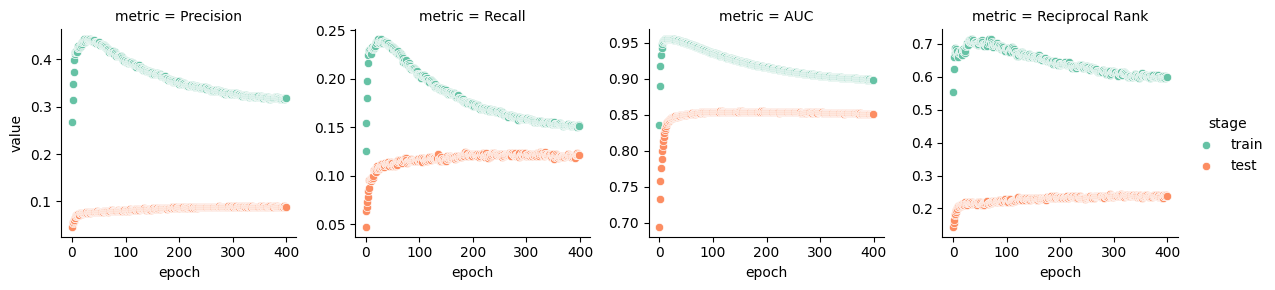

In [59]:
g = sns.FacetGrid(fitting_metrics, col="metric", hue="stage", col_wrap=4, sharey=False)
g = g.map(sns.scatterplot, "epoch", "value").add_legend()

In [1]:
import pickle

with open('lightdm_prec_0.09.pickle', 'wb') as fle:
    pickle.dump(model, fle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'model' is not defined

In [71]:
loaded_model = pickle.load(open('lightdm_prec_0.09.pickle', 'rb'))

In [90]:
n_users, n_items = test_interactions.shape
userid = 1
user_x = test_interactions.toarray()[userid]
scores = pd.Series(model.predict(user_x, np.arange(n_items), item_features=item_features, user_features=user_features))

In [91]:
scores.sort_values(ascending=False).head(10).index

Int64Index([1265, 859, 162, 178, 164, 86, 99, 8, 153, 36], dtype='int64')

In [ ]:
import scipy.sparse as sp

def format_newuser_input(user_feature_map, user_feature_list):
  #user_feature_map = user_feature_map  
  num_features = len(user_feature_list)
  normalised_val = 1.0 
  target_indices = []
  for feature in user_feature_list:
    try:
        target_indices.append(user_feature_map[feature])
    except KeyError:
        print("new user feature encountered '{}'".format(feature))
        pass
  #print("target indices: {}".format(target_indices))
  new_user_features = np.zeros(len(user_feature_map.keys()))
  for i in target_indices:
    new_user_features[i] = normalised_val
  new_user_features = sp.csr_matrix(new_user_features)
  return(new_user_features)